<a href="https://colab.research.google.com/github/gitguy007/2026-ColabWorks/blob/main/BizAnalysis_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6: Python Business Analytics


See the Repository for Future Work: https://github.com/firmai/python-business-analytics or


Sign up to the mailing list:
https://mailchi.mp/ec4942d52cc5/firmai

# Demand Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
rcParams['figure.figsize'] = 8, 6

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/test.csv')

Before we do anything, we want to have both sets in a format with 500 sales columns and 1 row for each day.

In [3]:
df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [4]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [5]:
from itertools import product, starmap


def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [6]:
df_train = sales_by_storeitem(df_train)
# for test set, we just fill y values with zeros (they won't be used anyway)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


We combine data to prepare it for the model, and later split back into train and test set, not to repeat same transformations twice.

In [9]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [10]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [11]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

In [12]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

In [13]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

In [14]:
assert df_total.isnull().any().any() == False

We also want to append sales from previous day to each row, which we will then use as input data.

In [15]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret


def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [16]:
df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)

In [17]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1020 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(20), float64(1000)
memory usage: 14.7 MB


We need to make sure that stacked and not-stacked sales columns appar in the same order. We do this by sorting the names (as strings), which works fine because we only need 1 past day for the network (see regression models and their rolling mechanism if you are interested in rolling more than 1 past days of sales as input).

In [18]:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [19]:
df_total = df_total.reindex(columns=new_cols)

In [20]:
assert df_total.isnull().any().any() == False

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

In [23]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [24]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [25]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: bool(19), float64(500)
memory usage: 7.0 MB


In [27]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [29]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

For Keras, we need to make further transformations on input values:

In [36]:
X_train_vals = X_train.astype(float).values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.astype(float).values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [31]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

Simple LSTM model:

In [32]:
basic_model = Sequential()
basic_model.add(LSTM(500, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(500))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

More complex model combining LSTM with convolutional layers:

In [34]:
inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
# top pipeline
top_lstm = LSTM(500)(inputs)
top_dense = Dense(500, activation='relu')(top_lstm)
top_dropout = Dropout(0.5)(top_dense) # Changed 500 to 0.5
# bottom pipeline
bottom_dense = Dense(500)(inputs)
bottom_conv1 = Conv1D(
    500,
    kernel_size=1,
    input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
)(bottom_dense)
bottom_conv2 = Conv1D(
    1000,
    kernel_size=50,
    padding='same',
    activation='relu'
)(bottom_conv1)
bottom_conv3 = Conv1D(
    500,
    kernel_size=10,
    padding='same',
    activation='relu'
)(bottom_conv2)
bottom_pooling = AvgPool1D(
    pool_size=60,
    padding='same'
)(bottom_conv3)
bottom_reshape = Reshape(
    target_shape=[500]
)(bottom_conv3)
# concat output from both pipelines
final_concat = Concatenate()([top_dropout, bottom_reshape])
final_dense = Dense(500)(final_concat)
# compile and return
complex_model = Model(inputs=inputs, outputs=final_dense)
complex_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

Now we can fit the models:

In [37]:
basic_history = basic_model.fit(
    X_train_vals,
    y_train.values,
    epochs=60,
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/60
49/49 - 3s - 53ms/step - loss: 0.1417 - val_loss: 0.1022
Epoch 2/60
49/49 - 0s - 6ms/step - loss: 0.0941 - val_loss: 0.0866
Epoch 3/60
49/49 - 0s - 6ms/step - loss: 0.0823 - val_loss: 0.0687
Epoch 4/60
49/49 - 0s - 6ms/step - loss: 0.0746 - val_loss: 0.0629
Epoch 5/60
49/49 - 0s - 6ms/step - loss: 0.0753 - val_loss: 0.0595
Epoch 6/60
49/49 - 0s - 6ms/step - loss: 0.0773 - val_loss: 0.0674
Epoch 7/60
49/49 - 0s - 6ms/step - loss: 0.0919 - val_loss: 0.1217
Epoch 8/60
49/49 - 0s - 6ms/step - loss: 0.0883 - val_loss: 0.0880
Epoch 9/60
49/49 - 0s - 6ms/step - loss: 0.0823 - val_loss: 0.0819
Epoch 10/60
49/49 - 0s - 6ms/step - loss: 0.0812 - val_loss: 0.0716
Epoch 11/60
49/49 - 0s - 6ms/step - loss: 0.0744 - val_loss: 0.0650
Epoch 12/60
49/49 - 0s - 6ms/step - loss: 0.0735 - val_loss: 0.0578
Epoch 13/60
49/49 - 0s - 6ms/step - loss: 0.0635 - val_loss: 0.0639
Epoch 14/60
49/49 - 0s - 6ms/step - loss: 0.0736 - val_loss: 0.0565
Epoch 15/60
49/49 - 0s - 6ms/step - loss: 0.0682 - val_l

In [38]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

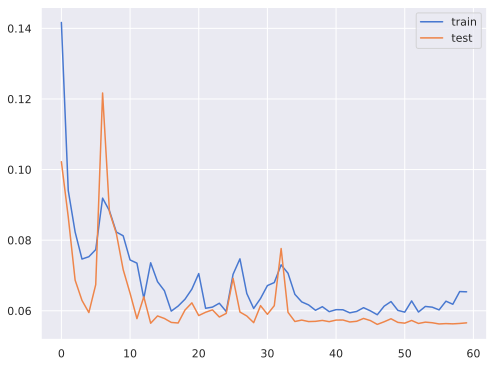

In [39]:
plot_history(basic_history)

In [40]:
complex_history = complex_model.fit(
    X_train_vals,
    y_train.values,
    epochs=20,
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Epoch 1/20
21/21 - 9s - 437ms/step - loss: 0.0758 - mape: 139.2201 - val_loss: 0.0110 - val_mape: 20.6656
Epoch 2/20
21/21 - 2s - 75ms/step - loss: 0.0167 - mape: 389.3465 - val_loss: 0.0082 - val_mape: 18.4943
Epoch 3/20
21/21 - 2s - 76ms/step - loss: 0.0123 - mape: 359.3033 - val_loss: 0.0070 - val_mape: 17.0647
Epoch 4/20
21/21 - 2s - 78ms/step - loss: 0.0091 - mape: 399.1594 - val_loss: 0.0058 - val_mape: 15.5114
Epoch 5/20
21/21 - 2s - 75ms/step - loss: 0.0069 - mape: 384.8029 - val_loss: 0.0052 - val_mape: 14.3022
Epoch 6/20
21/21 - 2s - 75ms/step - loss: 0.0132 - mape: 390.3756 - val_loss: 0.0109 - val_mape: 23.4353
Epoch 7/20
21/21 - 2s - 75ms/step - loss: 0.0250 - mape: 192.8239 - val_loss: 0.0094 - val_mape: 17.5060
Epoch 8/20
21/21 - 2s - 75ms/step - loss: 0.0080 - mape: 411.4087 - val_loss: 0.0059 - val_mape: 14.7060
Epoch 9/20
21/21 - 2s - 75ms/step - loss: 0.0075 - mape: 345.2591 - val_loss: 0.0070 - val_mape: 15.0695
Epoch 10/20
21/21 - 2s - 75ms/step - loss: 0.0064 - ma

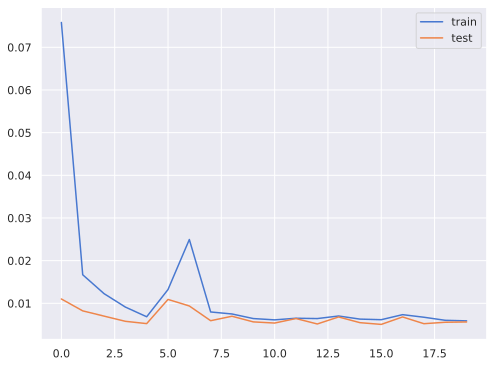

In [41]:
plot_history(complex_history)

## Evaluating model predictions

In [42]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values


def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [44]:
y_pred_basic, y_real = model_eval(basic_model, X_valid.astype(float), y_valid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

In [46]:
y_pred_complex = model_eval(complex_model, X_valid.astype(float), y_valid)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

In [47]:
# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [48]:
basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [49]:
basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

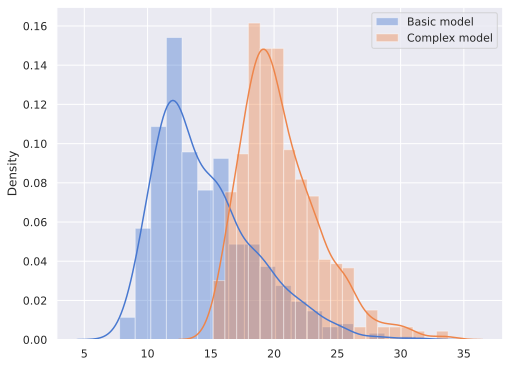

In [50]:
sns.distplot(basic_smapes, label='Basic model')
sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

Depending on training parameters, basic model can sometimes achieve results comparable to the complex one, however after uploading to Kaggle complex model achieved better (and more consistent) results.

In [51]:
describe(basic_smapes)

DescribeResult(nobs=np.int64(500), minmax=(np.float64(7.790898074596066), np.float64(31.21530736423322)), mean=np.float64(14.5697340180801), variance=np.float64(15.124410772848062), skewness=np.float64(0.9692982752963605), kurtosis=np.float64(0.7632694532699698))

In [52]:
describe(complex_smapes)

DescribeResult(nobs=np.int64(500), minmax=(np.float64(15.183600338181385), np.float64(33.76101476385697)), mean=np.float64(20.55496419955899), variance=np.float64(9.844779265781423), skewness=np.float64(1.0451950919745667), kurtosis=np.float64(1.3278987599786358))

### Visualizing model prediction
We will plot predictions of 2 models for a sample store and item.

In [53]:
store, item = 1,1
plot_lengths = [7, 30, 90]
rolling_mean_windows = [1, 1, 2]  # to make plots more readable

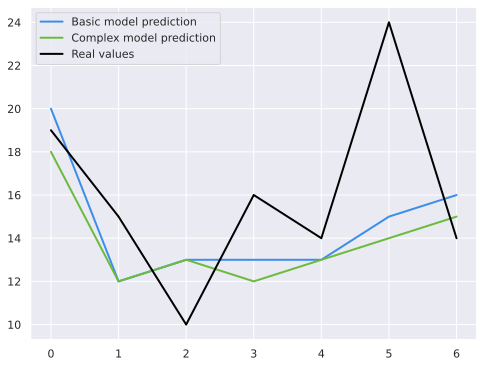

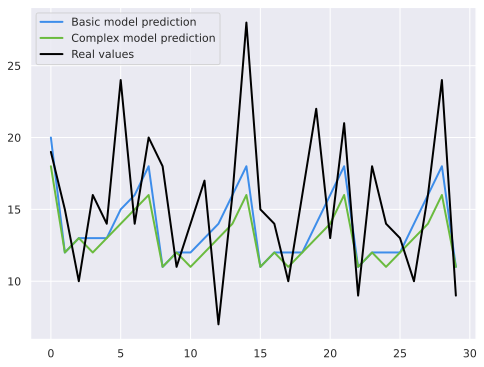

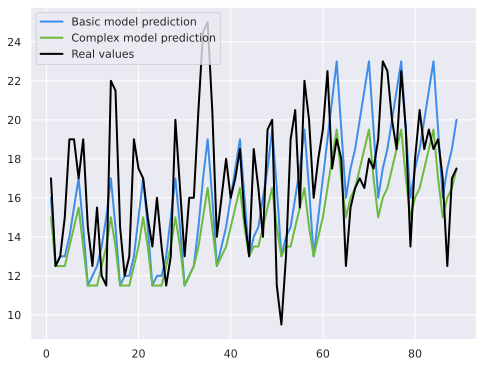

In [54]:
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(basic_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['blue'],
             lw=2,
             label='Basic model prediction')
    plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2,
             label='Complex model prediction')
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2,
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()

In [55]:
filename = 'neuralNetwork.sav'
filename1 = 'basicmodel.sav'

In [56]:
import pickle

In [57]:
pickle.dump(complex_model, open(filename, 'wb'))

In [58]:
pickle.dump(basic_model, open(filename1, 'wb'))

In [59]:
pd.DataFrame(complex_pred).to_csv("file.csv")

In [60]:
pd.DataFrame(real).to_csv("file1.csv")

Credit: [Vinay Ak](https://github.com/Vinayak02)

Repository: [Customer Centric](https://github.com/Vinayak02/CustomerCentricRetail)
